<a href="https://colab.research.google.com/github/LeograndeCode/Neural-Highlighting-of-Affordance-Regions/blob/Parte-3/Notebook3D_AffordanceNet_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive') #replace with drive.mount('/content/drive/', force_remount=True) if the drive has changed since last mount in order to force the remount
%cd /content/drive/MyDrive/Neural-Highlighting-of-Affordance-Regions/


Mounted at /content/drive
/content/drive/MyDrive/Neural-Highlighting-of-Affordance-Regions


In [2]:
!apt-get update
!apt-get install -y xvfb ffmpeg libsm6 libxext6
!pip install git+https://github.com/openai/CLIP.git
!pip install kaolin==0.17.0 -f https://nvidia-kaolin.s3.us-east-2.amazonaws.com/torch-2.5.1_cu121.html
!pip install open3d pyvirtualdisplay

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [3,527 kB]
Get:8 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,227 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [45.2 kB]
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,199 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,560 kB]
Hit:12 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hi

###AffordanceNet Class

AffordanceNet Class modified with capability of choosing only some objects, in our case household objects with hand-object affordances



In [3]:
import os
from os.path import join as opj
import numpy as np
from torch.utils.data import Dataset
import h5py
import json
import pickle as pkl

def pc_normalize(pc):
    centroid = np.mean(pc, axis=0)
    pc = pc - centroid
    m = np.max(np.sqrt(np.sum(pc**2, axis=1)))
    pc = pc / m
    return pc, centroid, m


class AffordNetDataset(Dataset):
    def __init__(self, data_dir):
        super().__init__()
        self.data_dir = data_dir
        self.semantic_class = 'Mug'
        self.label_name = 'grasp'
        self.load_data()
        return

    def load_data(self):
        self.all_data = []

        # Open the dataset file
        with open('full_shape_train_data.pkl', 'rb') as f:
            data = pkl.load(f)


        # Check if the data is a list
        if isinstance(data, list):
            # Filter the point clouds based on the 'semantic class' attribute
            point_clouds = [
                pc for pc in data
                if pc.get('semantic class') == self.semantic_class
            ]
        print(f"Number of point clouds with 'semantic class' equal to {self.semantic_class}: {len(point_clouds)}")

        self.all_data = point_clouds

    def __getitem__(self, index):
        data_dict = self.all_data[index]

        coordinates = np.array(data_dict['full_shape']['coordinate'])
        label = np.array(data_dict['full_shape']['label'][self.label_name])

        data, _, _ = pc_normalize(coordinates)

        return data, label

    def __len__(self):
        return len(self.all_data)


### Model

In [4]:
import clip
import copy
import json
import kaolin as kal
import kaolin.ops.mesh
import numpy as np
import os
import random
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as F

from itertools import permutations, product
from Normalization import MeshNormalizer
from render import Renderer
from mesh import Mesh
from pathlib import Path
from tqdm import tqdm
from torch.autograd import grad
from torchvision import transforms
from utils import device, color_mesh
import open3d as o3d
from pyvirtualdisplay import Display

# Pytorch3D install
import sys
pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
version_str="".join([
    f"py3{sys.version_info.minor}_cu",
    torch.version.cuda.replace(".",""),
    f"_pyt{pyt_version_str}"
])
!pip install iopath
!pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html


# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Pointclouds
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVOrthographicCameras,
    PointsRasterizationSettings,
    PointsRenderer,
    PulsarPointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor
)
from pytorch3d.io import load_objs_as_meshes, save_ply

width = 256
depth = 4       #default is 4
out_dim = 2
input_dim = 3
n_augs = 1      #default is 1

class NeuralHighlighter(nn.Module):
    def __init__(self):
        super(NeuralHighlighter, self).__init__()
        input_size = 3 #Dimension of the vertex
        output_size = 2 #Dimension of the output
                        #for the standard highlighter task there are only 2 classes: target region and not target region.
                        #we use the element of the output vector corresponding to the probability of belonging to the target
                        #region as the highlight probability described in the main paper.
        layers = []

        #See Appendix B (page 13)
        #first linear layer followed by ReLU and LayerNorm
        layers.append(nn.Linear(input_dim, width))
        layers.append(nn.ReLU())
        layers.append(nn.LayerNorm([width]))
        #other [depth] linear layers followed by ReLU and LayerNorm
        # -> changing the depth hyperparameter results in a deeper/shallower net
        # -> total depth (in terms of modules[Linear+ReLU+LayerNorm]) = [depth] + 1
        for i in range(depth):
            layers.append(nn.Linear(width, width))
            layers.append(nn.ReLU())
            layers.append(nn.LayerNorm([width]))
        #last linear layer followed by softmax in order to output probability-like values
        layers.append(nn.Linear(width, out_dim))
        layers.append(nn.Softmax(dim=1))

        self.mlp = nn.ModuleList(layers)
        self.model = self.mlp
        print(self.mlp)

    def forward(self, x):
        for layer in self.model:
            x = layer(x)
        return x

def get_clip_model(clipmodel):
    model, preprocess = clip.load(clipmodel, device=device)
    return model, preprocess

# ================== HELPER FUNCTIONS =============================
def save_final_results(log_dir, name, mesh, mlp, vertices, colors, render, background):
    mlp.eval()
    with torch.no_grad():
        probs = mlp(vertices)
        max_idx = torch.argmax(probs, 1, keepdim=True)
        # for renders
        one_hot = torch.zeros(probs.shape).to(device)
        one_hot = one_hot.scatter_(1, max_idx, 1)
        sampled_mesh = mesh

        highlight = torch.tensor([204, 255, 0]).to(device)
        gray = torch.tensor([180, 180, 180]).to(device)
        colors = torch.stack((highlight/255, gray/255)).to(device)
        color_mesh(one_hot, sampled_mesh, colors)
        rendered_images, _, _ = render.render_views(sampled_mesh, num_views=5,
                                                                        show=False,
                                                                        center_azim=0,
                                                                        center_elev=0,
                                                                        std=1,
                                                                        return_views=True,
                                                                        lighting=True,
                                                                        background=background)
        # for mesh
        final_color = torch.zeros(vertices.shape[0], 3).to(device)
        final_color = torch.where(max_idx==0, highlight, gray)
        mesh.export(os.path.join(log_dir, f"{name}.ply"), extension="ply", color=final_color)
        save_renders(log_dir, 0, rendered_images, name='final_render.jpg')

#TODO: fix the generation of the point cloud subsequently
#      now the point cloud generation is possible only by executing the PC_rendering.ipynb

def save_point_cloud_results(log_dir, name):
        #now i load the highlighted mesh and transpose it back to the point cloud
        display = Display(visible=0, size=(1400, 900))
        display.start()
        mesh_o3d = o3d.io.read_triangle_mesh(os.path.join(log_dir, f"{name}.ply"))

        if not mesh_o3d.has_vertex_normals():
          mesh_o3d.compute_vertex_normals()

        point_cloud = mesh_o3d.sample_points_poisson_disk(number_of_points=2048)

        width_final_render, height_final_render = 1400, 900
        render_final_pc = o3d.visualization.rendering.OffscreenRenderer(width_final_render, height_final_render)
        material = o3d.visualization.rendering.MaterialRecord()
        material.shader = "defaultUnlit"
        render_final_pc.scene.add_geometry("point_cloud", point_cloud, material)

        zoom_out_factor = 0.5
        bounding_box = point_cloud.get_axis_aligned_bounding_box()
        center = bounding_box.get_center()
        extent = bounding_box.get_extent()
        render_final_pc.scene.camera.look_at(center, center + [0, 0, 1], [0, 1, 0])
        render_final_pc.scene.camera.set_projection(60 / zoom_out_factor, width_final_render / height_final_render, 0.1, 100.0,
                                      o3d.visualization.rendering.Camera.FovType.Horizontal)

        pc_img = render_final_pc.render_to_image()
        output_file = os.path.join(log_dir, f"{name}_final_render.jpg")
        o3d.io.write_image(output_file, pc_img)
        display.stop()


def clip_loss(rendered_images, encoded_text, clip_transform, augment_transform, clip_model):
    if n_augs == 0:
        clip_image = clip_transform(rendered_images)
        encoded_renders = clip_model.encode_image(clip_image)
        encoded_renders = encoded_renders / encoded_renders.norm(dim=1, keepdim=True)
        if encoded_text.shape[0] > 1:
            loss = torch.cosine_similarity(torch.mean(encoded_renders, dim=0),
                                                torch.mean(encoded_text, dim=0), dim=0)
        else:
            loss = torch.cosine_similarity(torch.mean(encoded_renders, dim=0, keepdim=True),
                                                encoded_text)

    elif n_augs > 0:
        loss = 1.0 #original 0.0
        for _ in range(n_augs):
            augmented_image = augment_transform(rendered_images)
            encoded_renders = clip_model.encode_image(augmented_image)
            if encoded_text.shape[0] > 1:
                loss -= torch.cosine_similarity(torch.mean(encoded_renders, dim=0),
                                                    torch.mean(encoded_text, dim=0), dim=0)
            else:
                loss -= torch.cosine_similarity(torch.mean(encoded_renders, dim=0, keepdim=True),
                                                    encoded_text)
    return loss

def save_renders(dir, i, rendered_images, name=None):
    if name is not None:
        torchvision.utils.save_image(rendered_images, os.path.join(dir, name))
    else:
        torchvision.utils.save_image(rendered_images, os.path.join(dir, 'renders/iter_{}.jpg'.format(i)))

Warp 1.5.1 initialized:
   CUDA Toolkit 12.6, Driver 12.2
   Devices:
     "cpu"      : "x86_64"
     "cuda:0"   : "Tesla T4" (15 GiB, sm_75, mempool enabled)
   Kernel cache:
     /root/.cache/warp/1.5.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31528 sha256=bca929de5505708f1841b6c20b8904645dc1fce808f0a3b400dfa98bde08be38
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built iopath
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu121_pyt251/download.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.5/20.5 MB 142.4 MB/s eta 0:00:00


#Dataset

In [5]:
import open3d as o3d
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader
import torch  # If dataset uses PyTorch tensors

# Assuming AffordNetDataset is correctly initialized
data_dir = "."
dataset = AffordNetDataset(data_dir=data_dir)
print(len(dataset))
# Split dataset into test and validation indices
indexes = list(range(len(dataset)))
val_indexes, test_indexes = train_test_split(indexes, test_size=0.9, shuffle=True)

# Create Subsets
val_dataset = Subset(dataset, val_indexes)
test_dataset = Subset(dataset, test_indexes)

# DataLoaders
batch_size = 1  # Load one point cloud at a time for visualization
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Check dataset sizes
print(f"Valid Dataset Size: {len(val_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")


# Access a sample
point_cloud, affordance_labels = dataset[0]

print("Point Cloud Shape:", point_cloud.shape)
print("Affordance Labels Shape:", affordance_labels.shape)



Number of point clouds with 'semantic class' equal to Mug: 133
133
Valid Dataset Size: 13
Test Dataset Size: 120
Point Cloud Shape: (2048, 3)
Affordance Labels Shape: (2048, 1)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


#Training


In [6]:
def assign_colors(pred_class, colors, device):
    """
    Assign colors to points based on their probabilities.

    Args:
        pred_class (torch.Tensor): Tensor of shape [N, 2], where each row contains
                                   [p_highlighted, p_not_highlighted].
        colors (torch.Tensor): Tensor of shape [2, 3], where the first row is "highlighter" color
                               and the second row is "gray" color.
        device (torch.device): Device to which the tensors are moved (e.g., "cpu" or "cuda").

    Returns:
        torch.Tensor: A tensor of shape [N, 3] containing the RGB colors for each point.
    """
    # Ensure the probabilities are normalized (if not already)
    pred_class = pred_class / pred_class.sum(dim=1, keepdim=True)

    # Extract probabilities for highlighter and gray
    p_highlighter = pred_class[:, 0].unsqueeze(1)  # Shape: [N, 1]
    p_gray = pred_class[:, 1].unsqueeze(1)         # Shape: [N, 1]

    # Compute weighted colors
    colors_highlighter = colors[0].unsqueeze(0)  # Shape: [1, 3]
    colors_gray = colors[1].unsqueeze(0)        # Shape: [1, 3]

    # Weighted sum of the colors based on probabilities
    point_colors = p_highlighter * colors_highlighter + p_gray * colors_gray  # Shape: [N, 3]

    return point_colors.to(device)

Rendering Example


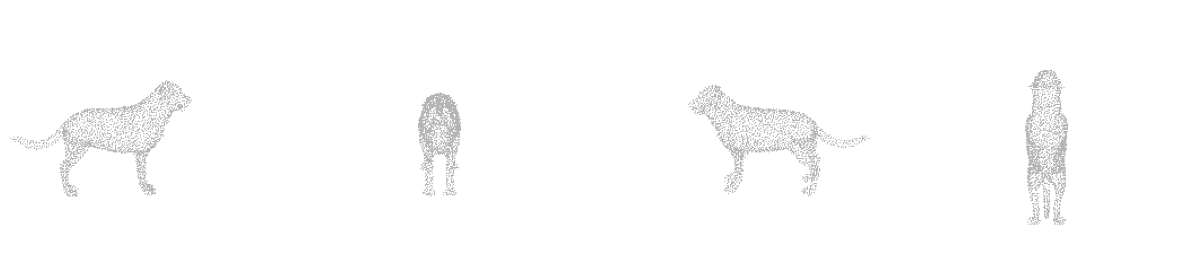

In [40]:
import matplotlib.pyplot as plt


obj_path = 'data/dog.obj'

device = "cuda" if torch.cuda.is_available() else "cpu"

#Path(os.path.join(output_dir, 'renders')).mkdir(parents=True, exist_ok=True)

objbase, extension = os.path.splitext(os.path.basename(obj_path))

# list of possible colors
rgb_to_color = {(204/255, 1., 0.): "highlighter", (180/255, 180/255, 180/255): "gray"}
color_to_rgb = {"highlighter": [204/255, 1., 0.], "gray": [180/255, 180/255, 180/255]}
full_colors = [[204/255, 1., 0.], [180/255, 180/255, 180/255]]
colors = torch.tensor(full_colors).to(device)

#------------ MESH TO POINT CLOUD INIT---------------
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

#here we retrieve first the point cloud from the mesh (only for test purpose)
mesh_o3d = o3d.io.read_triangle_mesh(obj_path)
mesh_o3d.compute_vertex_normals()
pcd = mesh_o3d.sample_points_poisson_disk(2048)
o3d.io.write_point_cloud("dog.pcd", pcd)
display.stop()
#------------ MESH TO POINT CLOUD END---------------

# Load the point cloud using Open3D
pcd = o3d.io.read_point_cloud("dog.pcd")

# Extract vertices and colors
points = torch.tensor(np.asarray(pcd.points), dtype=torch.float32, device = device)


# Create a tensor of gray colors for each point
gray_rgb = torch.tensor(color_to_rgb["gray"], dtype=torch.float32, device=device)  # Gray RGB value
gray_colors = gray_rgb.unsqueeze(0).repeat(points.shape[0], 1)  # Repeat gray for all points

# Create a PyTorch3D Pointclouds object
point_cloud = Pointclouds(points=[points], features=[gray_colors])

# Define multiple camera views
num_views = 4
elevations = [10, 20, 30, 40]  # Example elevation angles
azimuths = [0, 90, 180, 270]   # Example azimuth angles
Rs, Ts = zip(*(look_at_view_transform(20, elev, azim) for elev, azim in zip(elevations, azimuths)))

# Initialize rasterizer and renderer
raster_settings = PointsRasterizationSettings(
    image_size=224,
    radius=0.003,
    points_per_pixel=10
)
# Initialize variables
background = torch.tensor((1., 1., 1.)).to(device)

# Render images from multiple views
rendered_images = []
for R, T in zip(Rs, Ts):
    # Create a new camera for the current view
    cameras = FoVOrthographicCameras(device=device, R=R, T=T, znear=0.01)

    # Initialize the renderer with the new camera
    renderer = PulsarPointsRenderer(
        rasterizer=PointsRasterizer(cameras=cameras, raster_settings=raster_settings),
        n_channels=3
    ).to(device)

    # Render the image for the current camera view
    image = renderer(
        point_cloud,
        gamma=(1e-4,),
        bg_col=background
    )
    rendered_images.append(image[0, ..., :3].cpu().numpy())  # Extract RGB channels
import matplotlib.pyplot as plt

# Assuming rendered_images is a list of images (NumPy arrays)
num_images = len(rendered_images)

# Create a figure and axes for the combined image
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))  # Adjust figsize as needed

# Iterate through the rendered images and display them on the subplots
for i, image in enumerate(rendered_images):
    axes[i].imshow(image)
    axes[i].axis('off')  # Turn off axis labels and ticks

# Display the combined image
plt.show()

In [7]:
from torch.optim.lr_scheduler import MultiStepLR
import matplotlib.pyplot as plt
# Constrain most sources of randomness
# (some torch backwards functions within CLIP are non-determinstic)
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

render_res = 224
learning_rate = 0.0001
n_iter = 2500
res = 224
obj_path = 'data/dog.obj'
#output_dir = './output/'
clip_model_name = 'ViT-B/32'

device = "cuda" if torch.cuda.is_available() else "cpu"

#Path(os.path.join(output_dir, 'renders')).mkdir(parents=True, exist_ok=True)

objbase, extension = os.path.splitext(os.path.basename(obj_path))

# list of possible colors
rgb_to_color = {(204/255, 1., 0.): "highlighter", (180/255, 180/255, 180/255): "gray"}
color_to_rgb = {"highlighter": [204/255, 1., 0.], "gray": [180/255, 180/255, 180/255]}
full_colors = [[204/255, 1., 0.], [180/255, 180/255, 180/255]]
colors = torch.tensor(full_colors).to(device)

#------------ MESH TO POINT CLOUD INIT---------------
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

#here we retrieve first the point cloud from the mesh (only for test purpose)
mesh_o3d = o3d.io.read_triangle_mesh(obj_path)
mesh_o3d.compute_vertex_normals()
pcd = mesh_o3d.sample_points_poisson_disk(2048)
o3d.io.write_point_cloud("dog.pcd", pcd)
display.stop()
#------------ MESH TO POINT CLOUD END---------------

# Load the point cloud using Open3D
pcd = o3d.io.read_point_cloud("dog.pcd")

# Extract vertices and colors
points = torch.tensor(np.asarray(pcd.points), dtype=torch.float32, device = device)


# Create a tensor of gray colors for each point
gray_rgb = torch.tensor(color_to_rgb["gray"], dtype=torch.float32, device=device)  # Gray RGB value
gray_colors = gray_rgb.unsqueeze(0).repeat(points.shape[0], 1)  # Repeat gray for all points

# Create a PyTorch3D Pointclouds object
point_cloud = Pointclouds(points=[points], features=[gray_colors])

# Define multiple camera views
num_views = 4
elevations = [10, 20, 30, 40]  # Example elevation angles
azimuths = [0, 90, 180, 270]   # Example azimuth angles
Rs, Ts = zip(*(look_at_view_transform(20, elev, azim) for elev, azim in zip(elevations, azimuths)))

# Initialize rasterizer and renderer
raster_settings = PointsRasterizationSettings(
    image_size=224,
    radius=0.003,
    points_per_pixel=10
)
# Initialize variables
background = torch.tensor((1., 1., 1.)).to(device)

# CLIP and Augmentation Transforms
clip_normalizer = transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

clip_transform = transforms.Compose([
        transforms.Resize((res, res)),
        clip_normalizer
])

augment_transform = transforms.Compose([
        transforms.RandomResizedCrop(res, scale=(1, 1)),
        transforms.RandomPerspective(fill=1, p=0.8, distortion_scale=0.5),
        clip_normalizer
])

# MLP Settings
mlp = NeuralHighlighter().to(device)
optim = torch.optim.Adam(mlp.parameters(), learning_rate)

#introducing learning rate decay
#with the prompt horse/saddle the loss plateaus
#scheduler = StepLR(optim, step_size=300, gamma=0.1)

#scheduler = MultiStepLR(optim, milestones=[300, 1800], gamma=0.1)  # Decay a epoch 300 e 1800

name = 'dogPC_d_{}_augs_{}'.format(depth, n_augs)

# --- Prompt ---
# encode prompt with CLIP
clip_model, preprocess = get_clip_model(clip_model_name)
#prompts = ['A 3D render of a gray horse with highlighted hat',
#           'A 3D render of a gray horse with highlighted shoes',
#           'A 3D render of a gray horse with highlighted saddle']
prompts = ['A three-dimensional picture of a gray dog with highlighted belt']

for i, prompt in enumerate(prompts):

  output_dir = './output_{}_{}/'.format(name, i)
  Path(os.path.join(output_dir, 'renders')).mkdir(parents=True, exist_ok=True)
  log_dir = output_dir

  #here we compute the text encoding only once
  #if we put it inside the loss, we repeat n_iter times the same computation
  with torch.no_grad():
    text_input = clip.tokenize([prompt]).to(device)
    encoded_text = clip_model.encode_text(text_input)
    encoded_text = encoded_text / encoded_text.norm(dim=1, keepdim=True)

  n_views = 5

  losses = []


  # Optimization loop
  for i in tqdm(range(n_iter)):
    optim.zero_grad()

    # predict highlight probabilities
    pred_class = mlp(points)

    # color and render mesh
    sampled_pcd = point_cloud.clone()
    #point cloud coloring
    point_colors = assign_colors(pred_class, colors, device)
    sampled_pcd.features = point_colors

    # Render images from multiple views
    rendered_images = []
    for R, T in zip(Rs, Ts):
        # Create a new camera for the current view
        cameras = FoVOrthographicCameras(device=device, R=R, T=T, znear=0.01)

        # Initialize the renderer with the new camera
        renderer = PulsarPointsRenderer(
            rasterizer=PointsRasterizer(cameras=cameras, raster_settings=raster_settings),
            n_channels=3
        ).to(device)

        # Render the image for the current camera view
        image = renderer(
            point_cloud,
            gamma=(1e-4,),
            bg_col=background
        )
        rendered_images.append(image[0, ..., :3].cpu().numpy())  # Extract RGB channels

    rendered_images = torch.tensor(np.stack(rendered_images), dtype=torch.float32, device=device).permute(0, 3, 1, 2)

    # Calculate CLIP Loss
    loss = clip_loss(rendered_images, encoded_text, clip_transform, augment_transform, clip_model)

    #loss = clip_loss_custom(encoded_text, rendered_images, clip_model, preprocess)
    loss.backward(retain_graph=True)

    optim.step()

    #LR decay
    #scheduler.step()

    # update variables + record loss
    with torch.no_grad():
        losses.append(loss.item())

    # report results
    if i % 100 == 0:
        print("Last 100 CLIP score: {}".format(np.mean(losses[-100:])))
        save_renders(log_dir, i, rendered_images)
        with open(os.path.join(log_dir, "training_info.txt"), "a") as f:
            f.write(f"For iteration {i}... Prompt: {prompt}, Last 100 avg CLIP score: {np.mean(losses[-100:])}, CLIP score {losses[-1]}\n")

  # save point cloud results
  save_point_cloud_results(log_dir, name)



  # Save prompts
  with open(os.path.join(output_dir, 'prompt.txt'), "w") as f:
    f.write(prompt)
    f.write("\n")
    f.write("initial learning rate:")
    f.write(str(learning_rate))
    f.write("\n")
    f.write("n_iter:")
    f.write(str(n_iter))
    f.write("\n")
    f.write("n_augs:")
    f.write(str(n_augs))
    f.write("\n")
    f.write("n_views:")
    f.write(str(n_views))
    f.write("\n")
    f.write("clip_model:")
    f.write(clip_model_name)
    f.write("\n")
    f.write("depth:")
    f.write(str(depth))

ModuleList(
  (0): Linear(in_features=3, out_features=256, bias=True)
  (1): ReLU()
  (2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (3): Linear(in_features=256, out_features=256, bias=True)
  (4): ReLU()
  (5): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (6): Linear(in_features=256, out_features=256, bias=True)
  (7): ReLU()
  (8): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (9): Linear(in_features=256, out_features=256, bias=True)
  (10): ReLU()
  (11): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (12): Linear(in_features=256, out_features=256, bias=True)
  (13): ReLU()
  (14): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (15): Linear(in_features=256, out_features=2, bias=True)
  (16): Softmax(dim=1)
)


100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 111MiB/s]
  0%|          | 0/2500 [00:00<?, ?it/s]

Last 100 CLIP score: 0.71044921875


  4%|▍         | 100/2500 [00:12<03:33, 11.23it/s]

Last 100 CLIP score: 0.7127099609375


  8%|▊         | 200/2500 [00:22<04:44,  8.08it/s]

Last 100 CLIP score: 0.715341796875


 12%|█▏        | 300/2500 [00:31<03:16, 11.21it/s]

Last 100 CLIP score: 0.70986328125


 16%|█▌        | 400/2500 [00:41<03:06, 11.28it/s]

Last 100 CLIP score: 0.7133203125


 20%|██        | 500/2500 [00:51<03:00, 11.07it/s]

Last 100 CLIP score: 0.71013671875


 24%|██▍       | 601/2500 [01:02<04:35,  6.90it/s]

Last 100 CLIP score: 0.71220703125


 28%|██▊       | 701/2500 [01:11<03:12,  9.36it/s]

Last 100 CLIP score: 0.71123046875


 32%|███▏      | 801/2500 [01:21<03:08,  9.03it/s]

Last 100 CLIP score: 0.710361328125


 36%|███▌      | 901/2500 [01:31<04:10,  6.39it/s]

Last 100 CLIP score: 0.7122607421875


 40%|████      | 1001/2500 [01:40<02:52,  8.69it/s]

Last 100 CLIP score: 0.711318359375


 44%|████▍     | 1101/2500 [01:50<02:41,  8.69it/s]

Last 100 CLIP score: 0.7131298828125


 48%|████▊     | 1201/2500 [02:00<02:49,  7.66it/s]

Last 100 CLIP score: 0.7122900390625


 52%|█████▏    | 1301/2500 [02:09<02:15,  8.84it/s]

Last 100 CLIP score: 0.71138671875


 56%|█████▌    | 1401/2500 [02:19<02:00,  9.08it/s]

Last 100 CLIP score: 0.7103369140625


 60%|██████    | 1501/2500 [02:29<01:50,  9.00it/s]

Last 100 CLIP score: 0.713623046875


 64%|██████▍   | 1601/2500 [02:38<01:57,  7.67it/s]

Last 100 CLIP score: 0.712666015625


 68%|██████▊   | 1700/2500 [02:47<01:11, 11.12it/s]

Last 100 CLIP score: 0.7135888671875


 72%|███████▏  | 1799/2500 [02:57<01:03, 11.11it/s]

Last 100 CLIP score: 0.7126904296875


 76%|███████▌  | 1901/2500 [03:07<01:35,  6.29it/s]

Last 100 CLIP score: 0.71060546875


 80%|████████  | 2000/2500 [03:16<00:44, 11.22it/s]

Last 100 CLIP score: 0.71244140625


 84%|████████▍ | 2101/2500 [03:27<00:45,  8.75it/s]

Last 100 CLIP score: 0.7127783203125


 88%|████████▊ | 2201/2500 [03:36<00:38,  7.84it/s]

Last 100 CLIP score: 0.7106201171875


 92%|█████████▏| 2301/2500 [03:45<00:22,  8.87it/s]

Last 100 CLIP score: 0.7122119140625


 96%|█████████▌| 2400/2500 [03:55<00:08, 11.20it/s]

Last 100 CLIP score: 0.71376953125


100%|██████████| 2500/2500 [04:05<00:00, 10.19it/s]


[Open3D INFO] EGL headless mode enabled.


# Validation

In [ ]:
import os
from PIL import Image
import numpy as np
import torch
from tqdm import tqdm

def evaluate(dataloader, device):
    # Constrain most sources of randomness
    # (some torch backwards functions within CLIP are non-determinstic)
    seed = 0
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    device = "cuda" if torch.cuda.is_available() else "cpu"

    render_res = 224
    res = 224
    render = Renderer(dim=(render_res, render_res))
    background = torch.tensor((1., 1., 1.)).to(device)
    clip_model_name = 'ViT-B/32'


    # CLIP and Augmentation Transforms
    clip_normalizer = transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

    clip_transform = transforms.Compose([
            transforms.Resize((res, res)),
            clip_normalizer
    ])

    augment_transform = transforms.Compose([
            transforms.RandomResizedCrop(res, scale=(1, 1)),
            transforms.RandomPerspective(fill=1, p=0.8, distortion_scale=0.5),
            clip_normalizer
    ])


    net = NeuralHighlighter().to(device)
    net.eval()

    output_dir = 'output_Pt3'
    os.makedirs(output_dir, exist_ok=True)

    # list of possible colors
    rgb_to_color = {(204/255, 1., 0.): "highlighter", (180/255, 180/255, 180/255): "gray"}
    color_to_rgb = {"highlighter": [204/255, 1., 0.], "gray": [180/255, 180/255, 180/255]}
    full_colors = [[204/255, 1., 0.], [180/255, 180/255, 180/255]]
    colors = torch.tensor(full_colors).to(device)

    clip_model, preprocess = get_clip_model(clip_model_name)

    prompt = ['If you want to grap this mug, where will your palm position be?']


    n_views = 5

    with torch.no_grad():
        for i, (points, affordance_labels) in enumerate(tqdm(dataloader)):
            all_ious = []
            #here we compute the text encoding only once
            #if we put it inside the loss, we repeat n_iter times the same computation
            with torch.no_grad():
              text_input = clip.tokenize(prompt).to(device)
              encoded_text = clip_model.encode_text(text_input)
              encoded_text = encoded_text / encoded_text.norm(dim=1, keepdim=True)


            # -------------- POINT CLOUD TO MESH ---------------
            points = points.squeeze(0).to(device)  # Ensure points are on the correct device
            affordance_labels = affordance_labels.squeeze(0).to(device)  # Ensure labels are on the correct device

            # Create Open3D point cloud and mesh
            pcd = o3d.geometry.PointCloud()
            pcd.points = o3d.utility.Vector3dVector(points.cpu().numpy())  # Transfer points to CPU for Open3D

            # Estimate normals for the point cloud
            pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

            radii = [0.005, 0.01, 0.02, 0.04]
            mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(pcd, o3d.utility.DoubleVector(radii))

            # Export mesh to an obj file
            output_mesh_file = "mug.obj"
            o3d.io.write_triangle_mesh(output_mesh_file, mesh)

            mesh = Mesh(output_mesh_file)
            MeshNormalizer(mesh)  # Apply MeshNormalizer on CPU if necessary
            #--------------- END POINT CLOUD TO MESH -------------


            # Predict affordance
            vertices = copy.deepcopy(mesh.vertices)
            pred_class = net(vertices)  # Get predictions

            # color and render predicted mesh
            sampled_mesh = mesh
            color_mesh(pred_class, sampled_mesh, colors)
            rendered_images, elev, azim = render.render_views(sampled_mesh, num_views=n_views,
                                                                    show=False,
                                                                    center_azim=0,
                                                                    center_elev=0,
                                                                    std=1,
                                                                    return_views=True,
                                                                    lighting=True,
                                                                    background=background)


            # Compute IoU
            IOU_thres = np.linspace(0,1,20)

            pred_class = pred_class.cpu().numpy()

            # Keep the first column (index 0) only, resulting in shape (2048, 1)
            score = pred_class[:, 0].reshape(-1, 1)


            target_score = affordance_labels.squeeze().cpu().numpy()

            for thre in IOU_thres:
                t_mask = (target_score > thre).astype(int)
                p_mask = (score > thre).astype(int)
                intersection = np.sum(t_mask & p_mask)
                union = np.sum(p_mask | t_mask)

                if union == 0:
                    all_ious.append(np.nan)
                else:
                    all_ious.append(1. * intersection/union)

            ious_array = np.array(all_ious)
            mIOU = np.nanmean(all_ious)
            print(f"Mean Intersection over Union (mIOU): {mIOU:.4f}")

        return mIOU



def combine_images(pred_image, gt_image):
    """Combine two images side by side."""
    pred_image_np = (pred_image.detach().cpu().numpy() * 255).astype(np.uint8).transpose(1, 2, 0)
    gt_image_np = (gt_image.detach().cpu().numpy() * 255).astype(np.uint8).transpose(1, 2, 0)

    pred_pil = Image.fromarray(pred_image_np)
    gt_pil = Image.fromarray(gt_image_np)

    combined_width = pred_pil.width + gt_pil.width
    combined_height = max(pred_pil.height, gt_pil.height)
    combined_image = Image.new('RGB', (combined_width, combined_height))

    combined_image.paste(pred_pil, (0, 0))
    combined_image.paste(gt_pil, (pred_pil.width, 0))

    return combined_image


print("Starting evaluation...")
mIOU = evaluate(val_loader, device)
print(f"Mean Intersection over Union (mIOU): {mIOU:.4f}")




Starting evaluation...
ModuleList(
  (0): Linear(in_features=3, out_features=256, bias=True)
  (1): ReLU()
  (2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (3): Linear(in_features=256, out_features=256, bias=True)
  (4): ReLU()
  (5): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (6): Linear(in_features=256, out_features=256, bias=True)
  (7): ReLU()
  (8): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (9): Linear(in_features=256, out_features=256, bias=True)
  (10): ReLU()
  (11): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (12): Linear(in_features=256, out_features=256, bias=True)
  (13): ReLU()
  (14): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (15): Linear(in_features=256, out_features=2, bias=True)
  (16): Softmax(dim=1)
)


  0%|          | 0/13 [00:00<?, ?it/s]

[Open3D WARNING] Write OBJ can not include triangle normals.


  8%|▊         | 1/13 [00:01<00:18,  1.51s/it]

Mean Intersection over Union (mIOU): 0.0112
[Open3D WARNING] Write OBJ can not include triangle normals.


 15%|█▌        | 2/13 [00:02<00:12,  1.15s/it]

Mean Intersection over Union (mIOU): 0.0500
[Open3D WARNING] Write OBJ can not include triangle normals.


 23%|██▎       | 3/13 [00:03<00:09,  1.00it/s]

Mean Intersection over Union (mIOU): 0.0000
[Open3D WARNING] Write OBJ can not include triangle normals.


 31%|███       | 4/13 [00:03<00:08,  1.12it/s]

Mean Intersection over Union (mIOU): 0.1890
[Open3D WARNING] Write OBJ can not include triangle normals.


 38%|███▊      | 5/13 [00:04<00:06,  1.17it/s]

Mean Intersection over Union (mIOU): 0.0343
[Open3D WARNING] Write OBJ can not include triangle normals.


 46%|████▌     | 6/13 [00:05<00:05,  1.21it/s]

Mean Intersection over Union (mIOU): 0.0490
[Open3D WARNING] Write OBJ can not include triangle normals.


 54%|█████▍    | 7/13 [00:06<00:05,  1.01it/s]

Mean Intersection over Union (mIOU): 0.0397
[Open3D WARNING] Write OBJ can not include triangle normals.


 62%|██████▏   | 8/13 [00:07<00:04,  1.11it/s]

Mean Intersection over Union (mIOU): 0.0828
[Open3D WARNING] Write OBJ can not include triangle normals.


 69%|██████▉   | 9/13 [00:08<00:03,  1.11it/s]

Mean Intersection over Union (mIOU): 0.0393
[Open3D WARNING] Write OBJ can not include triangle normals.


 77%|███████▋  | 10/13 [00:09<00:02,  1.14it/s]

Mean Intersection over Union (mIOU): 0.0468
[Open3D WARNING] Write OBJ can not include triangle normals.


 85%|████████▍ | 11/13 [00:09<00:01,  1.24it/s]

Mean Intersection over Union (mIOU): 0.0422
[Open3D WARNING] Write OBJ can not include triangle normals.


 92%|█████████▏| 12/13 [00:10<00:00,  1.26it/s]

Mean Intersection over Union (mIOU): 0.0177
[Open3D WARNING] Write OBJ can not include triangle normals.


100%|██████████| 13/13 [00:11<00:00,  1.33it/s]

Mean Intersection over Union (mIOU): 0.0320


100%|██████████| 13/13 [00:11<00:00,  1.12it/s]

Mean Intersection over Union (mIOU): 0.0320


### Test
